# Task 2. Linear regression, gradient descent method


#### Азизи Бахрам (336243) Г: S4101

###### Tasks completed
* Independently implement the function gradient_descent and all of its version
* Scaling (Standardization)
* Data Cleaning 
* Perform exploratory analysis ( EDA )
* Feature Engineering
* Dimensionality Reduction
* Randomly split the data into training and test sets using the methods of existing libraries
* Assess the quality of the model on the training and test sets using MSE , RMSE and R^2
* Use of sklearn for L2-regulator with Ridge to campare my regression
* cross-validation
* Create a table, with rows (mse-train, mse-test, rmse-train, rmse-test, r2-train, r2-test) and columns (Fold1, Fold2, ..., Foldk, E, STD), where k --- number of folds in cross-validation, E --- mat. expectation and STD --- standard deviation. 


Dataset is downloaded from here: https://www.kaggle.com/amitabhajoy/bengaluru-house-price-data

### Let's Import all necessary libraries

In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_validate
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge
from sklearn import preprocessing
from sklearn.model_selection import KFold


In [12]:
import os

# This is my file path for the lab works
os.chdir("C:/Users/bahra/Desktop/ITMO Master's/2nd Semester/Deep Learning/Lab_2")

## 1. Let's define the Gradient Descent Function (all versions) with Metrix-Vector and MSE-L2 Regularization For Cost Function

#### Gradient Descent (Batch Version)

In [13]:
#Define the model Class
class GradientDescent:
    def __init__(self,lr,epoch):
        self.theta = None
        self.lr = lr
        self.epoch = epoch

    def fit(self,X_train,y_train,eps=0.0000001):
        """ Train/Fit Function
        Calculate theta iteratively using the update rule. 
        eps= Precision. We set the precision to define a point of convergence"""
        d =X_train.shape[1]
        
        cost = [] #initiate cost as a list to be used for storing and plotting the loss at each iteration
        self.theta = np.random.rand(d,1) #initiate theta as a random set of numbers with same shape as X features
        m = 1/(len(y_train))
        #print(self.theta.shape)
        for i in range(self.epoch): #define a for loop for the iterative process
            prev_theta = self.theta #storing the initial value of theta for to compare with precision of thresh if set
        #define the derviative of the loss function(the gradient)
            single_X = X_train[i].reshape(1,-1)
            grad = single_X.T@(single_X@self.theta - y_train[i])
            
            
        #Also represented as: grad = (X_train@theta - y_train)@X_train
        #define the update rule
            self.theta = self.theta - self.lr * (1/m) * grad
            ridge_reg_term = (1 / 2 * m) * np.sum(np.square(self.theta))
            loss = (1/m) * np.sum(((single_X@self.theta)-y_train)**2) + ridge_reg_term
            diff = np.sum(prev_theta - self.theta) #Setting a precision
            
            if diff <= eps:
                break
            cost.append(loss)
            plt.plot(cost) #Plot loss during training
                
        
        return self.theta
    
        
    def predict(self,X_test):
        """ Predict Function on Test set"""
        self.y_pred = np.dot(X_test, self.theta)
        
        return self.y_pred

#### Gradient Descent (Stochastic Version)

In [14]:
#Define the model Class
class SGD:
    def __init__(self,lr,epoch):
        self.theta = None
        self.lr = lr
        self.epoch = epoch

    def fit(self,X_train,y_train,eps=0.0000001):
        """ Train/Fit Function
        Calculate theta iteratively using the update rule. 
        eps= Precision. We set the precision to define a point of convergence"""
        d =X_train.shape[1]
        
        cost = [] #initiate cost as a list to be used for storing and plotting the loss at each iteration
        self.theta = np.random.rand(d,1) #initiate theta as a random set of numbers with same shape as X features
        m = 1/(len(y_train))
        #print(self.theta.shape)
        for j in range(self.epoch): #define a for loop for the iterative process over all training data(epoch)
            for i in range(X_train.shape[0]): ##define a for loop for the iterative process over a single training data(iteration)
                prev_theta = self.theta #storing the initial value of theta for to compare with precision of thresh if set
        
                single_X = X_train[i].reshape(1,-1) #to avoid matmul error. We now have X has a row vector, so we need to reshape.
        #define the derviative of the loss function(the gradient)
        
                grad = single_X.T@(single_X@self.theta - y_train[i])
        #Also represented as: grad = (X_train@theta - y_train)@X_train
        #define the update rule
                self.theta = self.theta - self.lr * (1/m) * grad
            
#                 Cost Function MSE + L2
                ridge_reg_term = (1 / 2 * m) * np.sum(np.square(self.theta))
                loss = (1/m) * np.sum(((single_X@self.theta)-y_train[i])**2) + ridge_reg_term
                diff = np.sum(prev_theta - self.theta) #Setting a precision
                if diff <= eps:
                    break
                cost.append(loss)
                plt.plot(cost) #Plot loss during training
            
        return self.theta
        
    def predict(self,X_test):
        """ Predict Function on Test set"""
        self.y_pred = np.dot(X_test, self.theta)
        
        return self.y_pred

#### Gradient Descent (Mini Batch Version)

In [15]:
#Define the model Class
class MBGD:
    def __init__(self,lr,epoch):
        self.theta = None
        self.lr = lr
        self.epoch = epoch

    def fit(self,X_train,y_train, batch_size = 4,eps=0.0000001):
        """ Train/Fit Function
        Calculate theta iteratively using the update rule. 
        eps= Precision. We set the precision to define a point of convergence"""
        d =X_train.shape[1]
        total_samples = X_train.shape[0]
        
        if batch_size > total_samples: # In this case mini batch becomes same as batch gradient descent
            batch_size = total_samples
        
        num_batches = int(total_samples/batch_size)
        
        
        cost = [] #initiate cost as a list to be used for storing and plotting the loss at each iteration
        self.theta = np.random.rand(d,1) #initiate theta as a random set of numbers with same shape as X features
        m = 1/(len(y_train))
        
        
        #print(self.theta.shape)
        for i in range(self.epoch): #define a for loop for the iterative process
            random_indices = np.random.permutation(total_samples)
            X_tmp = X_train[random_indices]
            y_tmp = y_train[random_indices]
            for j in range(0,total_samples,batch_size):
                prev_theta = self.theta #storing the initial value of theta for to compare with precision of thresh if set
                #define the derviative of the loss function(the gradient)
                single_X = X_train[i].reshape(1,-1)
                grad = single_X.T@(single_X@self.theta - y_train[i])
                #Also represented as: grad = (X_train@theta - y_train)@X_train
                #define the update rule
                
                self.theta = self.theta - self.lr * (1/m) * grad
                #Cost Function MSE + L2
                ridge_reg_term = (1 / 2 * m) * np.sum(np.square(self.theta))
                loss = (1/m) * np.sum(((single_X@self.theta)-y_train[i])**2) + ridge_reg_term
                diff = np.sum(prev_theta - self.theta) #Setting a precision
                if diff <= eps:
                    break
                cost.append(loss)
                plt.plot(cost) #Plot loss during training
        
        return self.theta
        
    def predict(self,X_test):
        """ Predict Function on Test set"""
        self.y_pred = np.dot(X_test, self.theta)
        
        return self.y_pred

# 2. Loading the dataset into a dataframe

In [16]:
# Let's read the data
df = pd.read_csv("b_h_d.csv")
# Let's see what we have
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


##### Wich feature are import for a house to buy and effects the price

* total_sqft is must
* number of bathrooms is also important
* price it self is feature which will be the main feature for predicting and building the model y
* location is also import
* balcony is also effecting the price of a house (at least in our country)

In [17]:
df.shape

(13320, 9)

In [18]:
df.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [19]:
df.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


In [20]:
df['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [21]:
df['area_type'].value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

### Drop features that are not required for future uses

* These four features are not that much important for the prices of a house

In [22]:
df2 = df.drop(['area_type','society','balcony','availability'],axis='columns')
df2.shape

(13320, 5)

### Data Cleaning: Handle NA values

In [23]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [24]:
df2.shape

(13320, 5)

In [25]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [26]:
df3.shape

(13246, 5)

In [27]:
df3.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


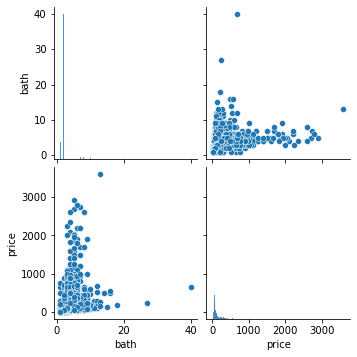

In [28]:
# Let's compare the price with other variables
sns.pairplot(df3)

#### Analysis
* As we can see there are some outliers in variable bath
* We can observe that price is going high with bath more baths

### Feature Engineering
#### Add new feature(integer) for bhk (Bedrooms Hall Kitchen)

In [29]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

C:\Users\bahra\AppData\Local\Temp\ipykernel_26292\2716584372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

**Explore total_sqft feature**

In [30]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [31]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


**Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple**

In [32]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None   

In [33]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(2)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4


**For below row, it shows total_sqft as 2475 which is an average of the range 2100-2850**

In [34]:
df4.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

In [35]:
(2100+2850)/2

2475.0

#### Feature Engineering: Add new feature called price per square feet

In [36]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [37]:
df5_stats = df5['price_per_sqft'].describe()
df5_stats

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

In [38]:
df5.to_csv("bhp.csv",index=False)

**Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations**

In [39]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

Whitefield                   533
Sarjapur  Road               392
Electronic City              304
Kanakpura Road               264
Thanisandra                  235
                            ... 
Rajanna Layout                 1
Subramanyanagar                1
Lakshmipura Vidyaanyapura      1
Malur Hosur Road               1
Abshot Layout                  1
Name: location, Length: 1287, dtype: int64

In [40]:
location_stats.values.sum()

13200

In [41]:
len(location_stats[location_stats>10])

240

In [42]:
len(location_stats)

1287

In [43]:
len(location_stats[location_stats<=10])

1047

### Dimensionality Reduction

**Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns**

In [44]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

BTM 1st Stage                10
Gunjur Palya                 10
Nagappa Reddy Layout         10
Sector 1 HSR Layout          10
Thyagaraja Nagar             10
                             ..
Rajanna Layout                1
Subramanyanagar               1
Lakshmipura Vidyaanyapura     1
Malur Hosur Road              1
Abshot Layout                 1
Name: location, Length: 1047, dtype: int64

In [45]:
len(df5.location.unique())

1287

In [46]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

241

In [47]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


### Outlier Removal Using Business Logic

**As a data analyst when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft**

In [48]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


**Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely**

In [49]:
df5.shape

(13200, 7)

In [50]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12456, 7)

### Outlier Removal Using Standard Deviation and Mean

In [51]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

**Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation**

In [52]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(10242, 7)

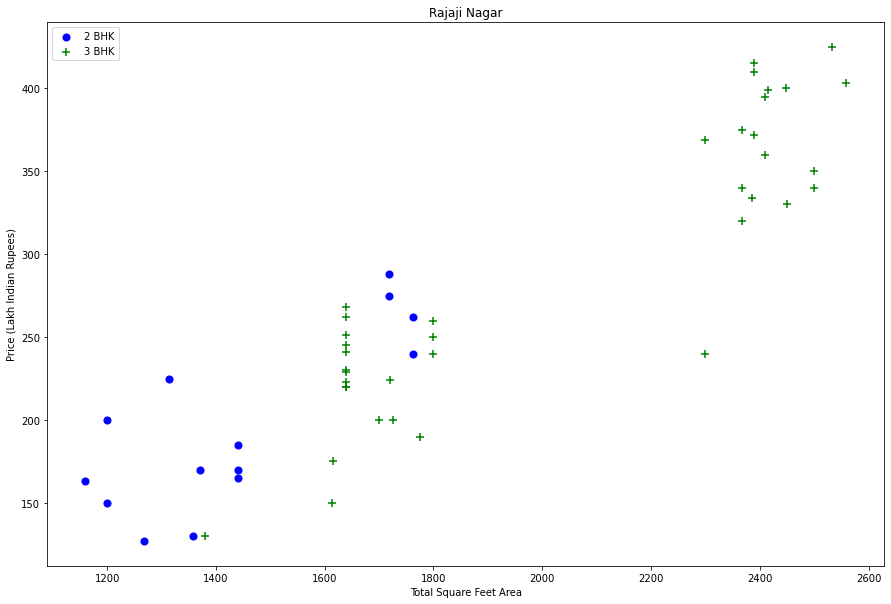

In [53]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Rajaji Nagar")

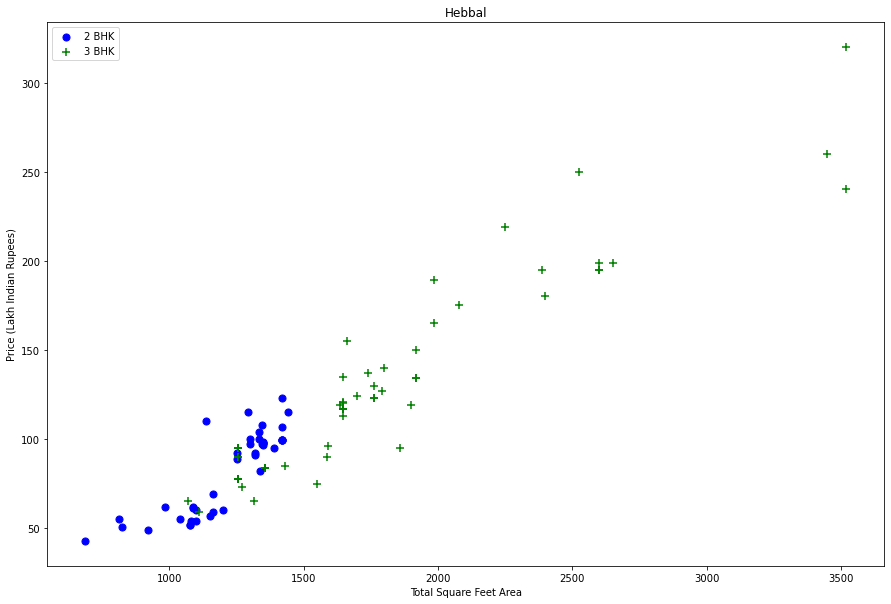

In [54]:
plot_scatter_chart(df7,"Hebbal")

**We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.**
```
{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    
}
```
**Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment**

In [55]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape

(7317, 7)

**Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties**

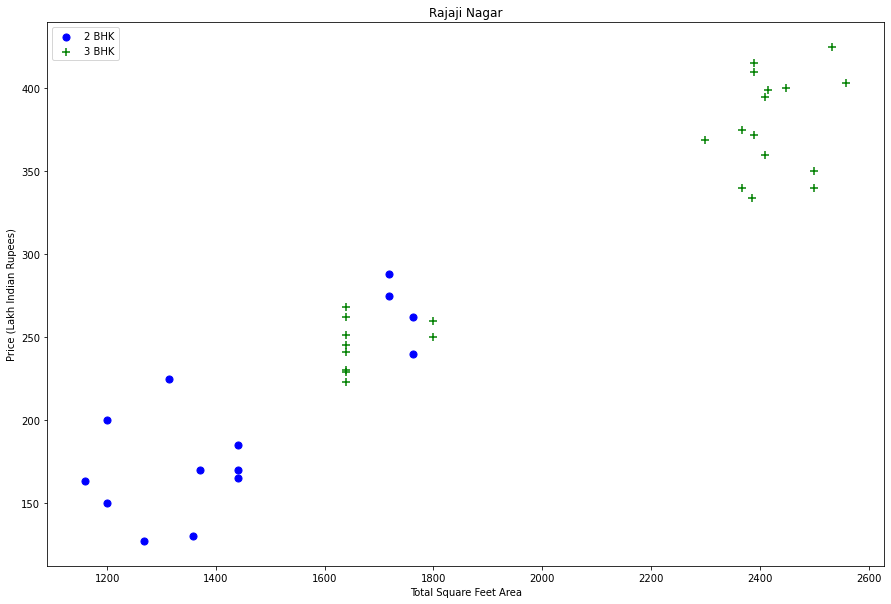

In [56]:
plot_scatter_chart(df8,"Rajaji Nagar")

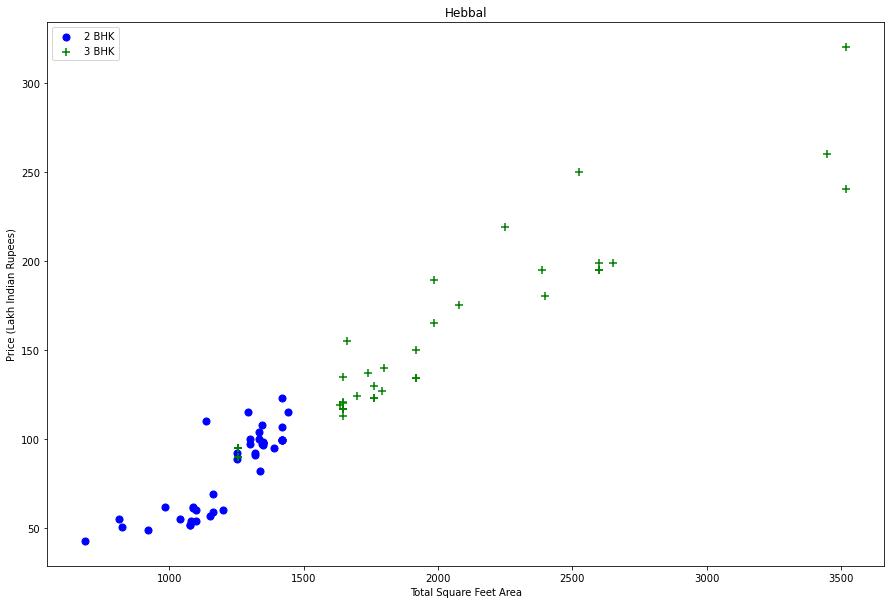

In [57]:
plot_scatter_chart(df8,"Hebbal")

**Based on above charts we can see that data points highlighted in red below are outliers and they are being removed due to remove_bhk_outliers function**

Text(0, 0.5, 'Count')

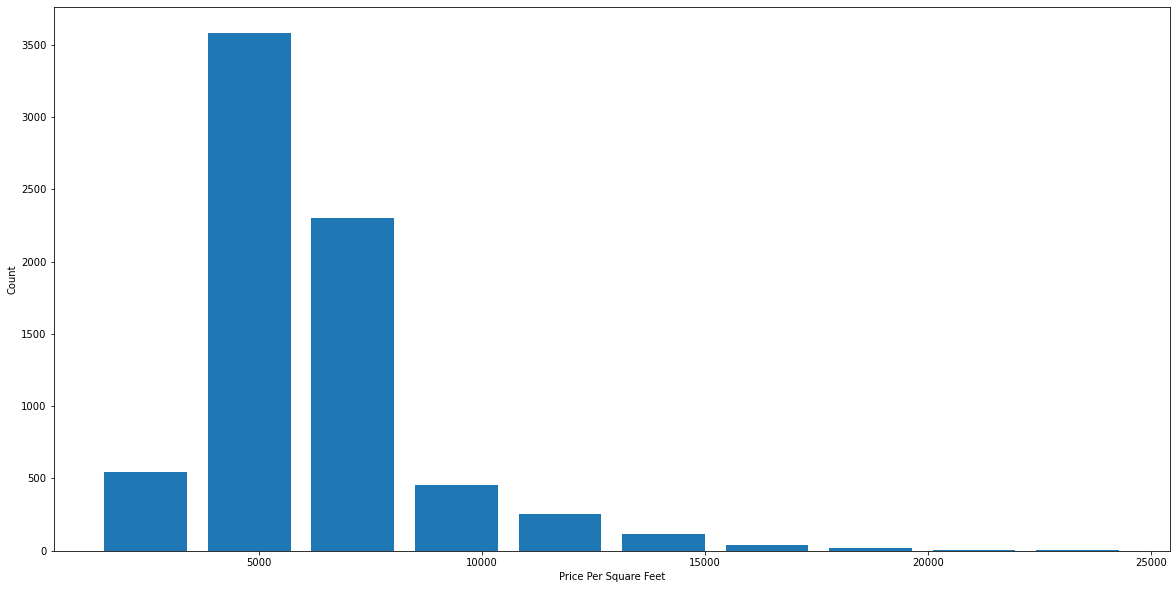

In [58]:
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

### Outlier Removal Using Bathrooms Feature

In [59]:
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

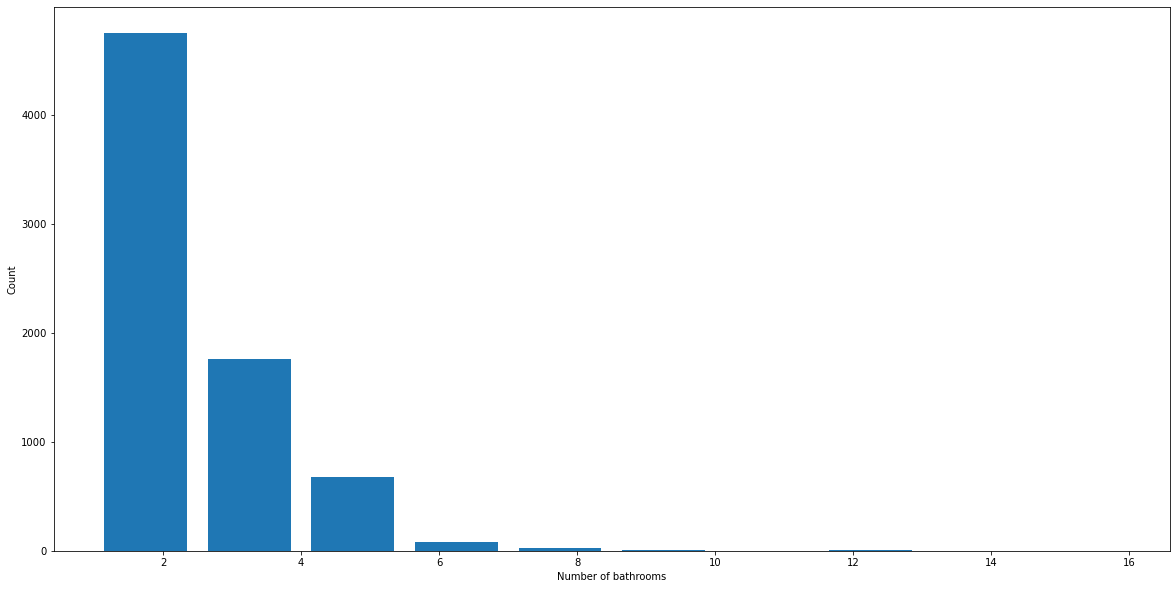

In [60]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [61]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8483,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8572,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9306,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9637,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


**It is unusual to have 2 more bathrooms than number of bedrooms in a home**

In [62]:
df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8408,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


* I am removing the size and price_per_sqft columns, because it was only for calculation and data cleaning purposes

In [63]:
df9 = df8.drop(['size','price_per_sqft'],axis='columns')
df9.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3


### Use One Hot Encoding For Location

* I will be using pandas get_dummies for one hot endcoing
* As you may know there other methods for achieving such results

In [64]:
dummies = pd.get_dummies(df9.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
df10 = pd.concat([df9,dummies.drop('other',axis='columns')],axis='columns')
df10.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
df11 = df10.drop('location',axis='columns')
df11.head(2)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


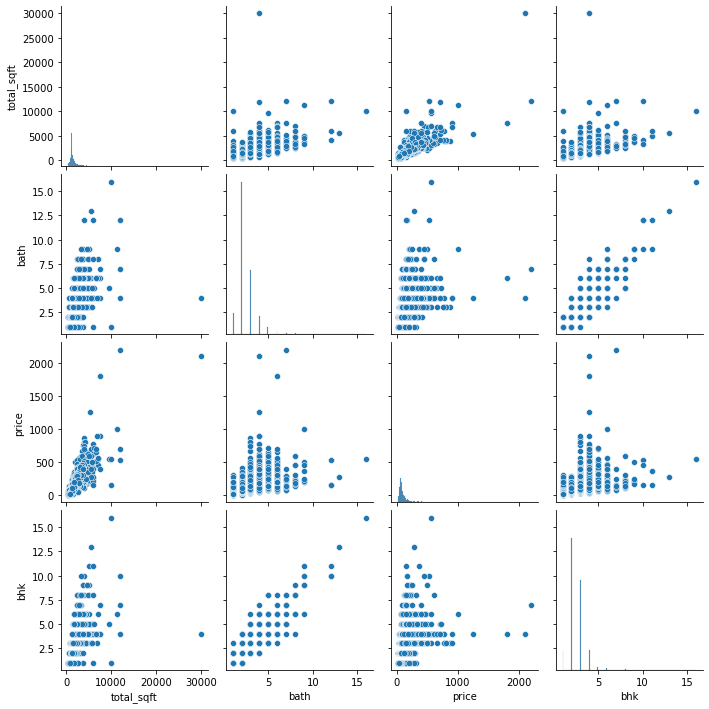

In [67]:
# Let's compare the price with other variables
sns.pairplot(df9)

### Analysis

* Now our dataset is looking good enough to make models for predictions or other usages
* We see bhk is going hight when bath is increasing
* We can see total_sqft is increasing when the price is increases
and so on..

# 3. Recursive Feature Elimination (RFE) from sklearn


**As you can see our dataset is already in its optimal form, we have already removed unessecry features. For the task purposes, I will demonstrate how to select the features with RFE**

In [68]:
cols = ["total_sqft","bath","bhk"] 
X = df11[cols]
y = df11['price']
# отберём с помощью RFE 3 признаков
rfe = RFE(estimator=LinearRegression(), n_features_to_select=3)
rfe = rfe.fit(X, y)
# выведем эти 3 признаков

selected_features= list(X.columns[rfe.support_])
print('Selected features: %s' % list(X.columns[rfe.support_]))

Selected features: ['total_sqft', 'bath', 'bhk']


# 4. Split the data into train and test samples

In [69]:
# Our train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 1234)

#### 4.1 Data preprocessing to scale our data

In [70]:
sx = preprocessing.MinMaxScaler()
sy = preprocessing.MinMaxScaler()
tx = preprocessing.MinMaxScaler()
ty = preprocessing.MinMaxScaler()

scaled_X = sx.fit_transform(X_train)
scaled_y = sy.fit_transform(y_train.values.reshape(y_train.shape[0],1))

scaled_tX = tx.fit_transform(X_test)
scaled_ty = ty.fit_transform(y_test.values.reshape(y_test.shape[0],1))

# 5. Modeling our data 

## 5.1 Let's use Batch Gradient Descent

array([[ 0.15455858],
       [ 0.41522335],
       [-0.00779855]])

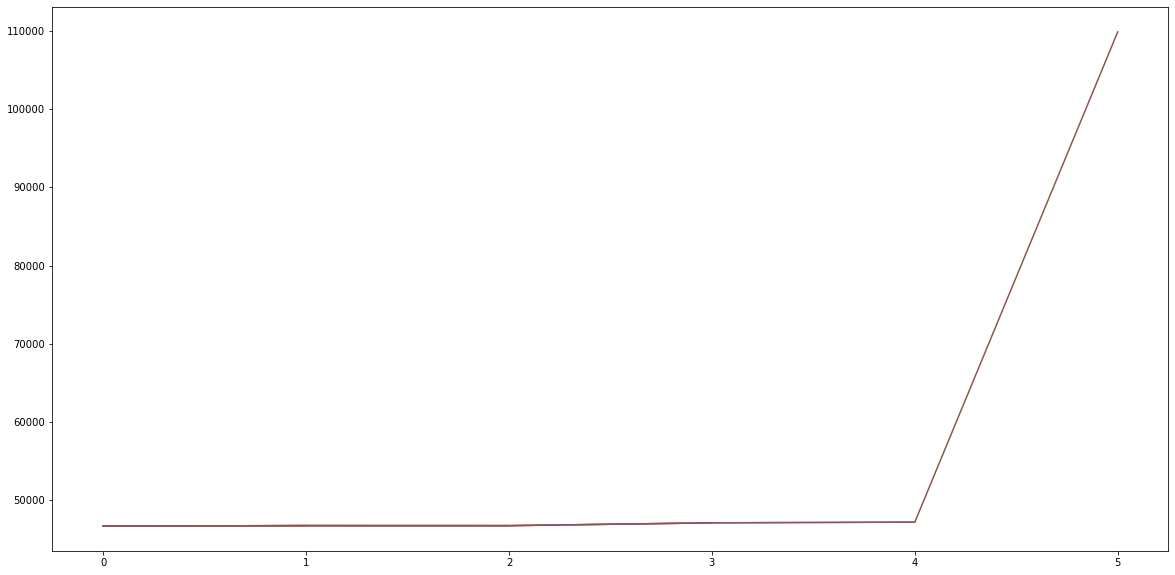

In [71]:
modelGD = GradientDescent(lr=0.001,epoch=100)
modelGD.fit(scaled_X,scaled_y.reshape(scaled_y.shape[0],))

### 5.1.2 Assessing our model with train and test data

### MSE, RMSE and R^2

In [109]:
mse = mean_squared_error(scaled_ty,modelGD.predict(scaled_tX))
rmse = mean_squared_error(scaled_ty,modelGD.predict(scaled_tX),squared=False)
r2 = r2_score(scaled_ty,modelGD.predict(scaled_tX))

print("MSE: ", mse)
print("MSE: ", rmse)
print("R^2: ", r2)

MSE:  0.0028479733934375483
MSE:  0.053366406975151964
R^2:  0.4034330108240578


## 5.2 Let's use Stochastic Gradient Descent

array([[ 0.72184191],
       [-0.07977068],
       [ 0.18607094]])

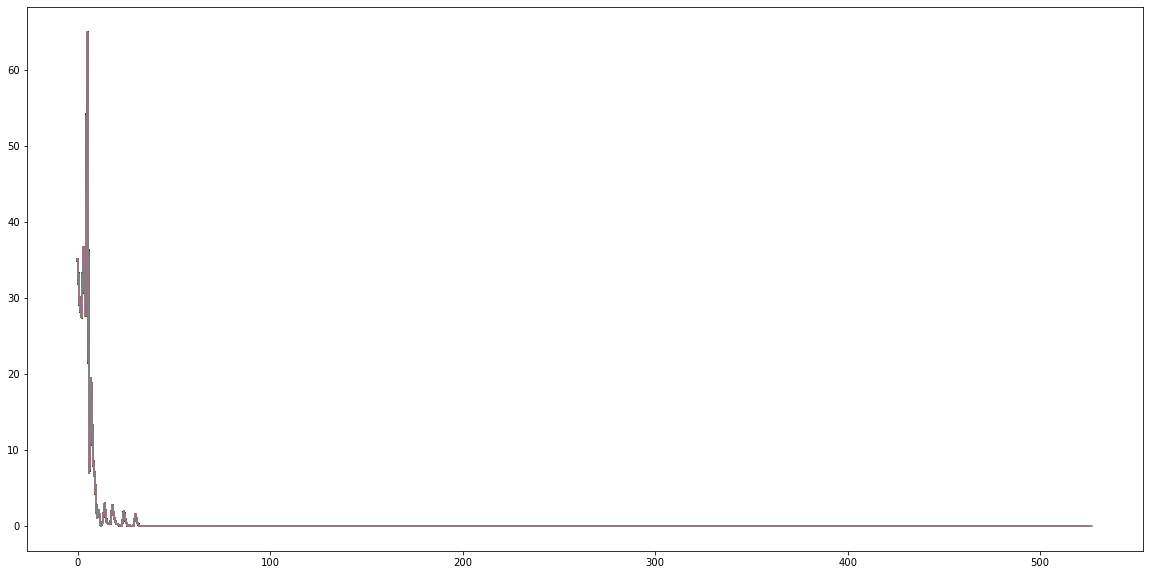

In [73]:
modelSGD = SGD(lr=0.001,epoch=500)
modelSGD.fit(scaled_X,scaled_y.reshape(scaled_y.shape[0],))

### 5.2.1 Assessing our model with train and test data

### MSE, RMSE and R^2

In [74]:
mse = mean_squared_error(scaled_ty,modelSGD.predict(scaled_tX))
rmse = mean_squared_error(scaled_ty,modelSGD.predict(scaled_tX),squared=False)
r2 = r2_score(scaled_ty,modelSGD.predict(scaled_tX))

print("MSE: ", mse)
print("MSE: ", rmse)
print("R^2: ", r2)

MSE:  0.0029061827706932243
MSE:  0.053909023091623764
R^2:  0.3912398516424298


## 5.3 Let's use Mini Batch Gradient Descent

array([[ 0.59787707],
       [ 0.17100909],
       [-0.02332104]])

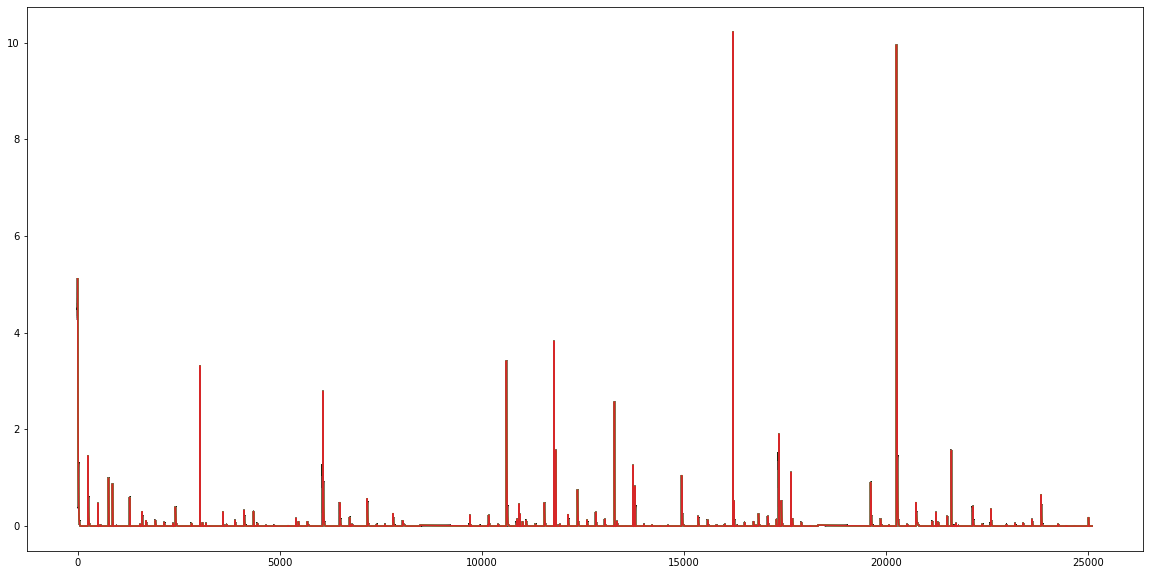

In [75]:
modelMBGD = MBGD(lr=0.001,epoch=500)
modelMBGD.fit(scaled_X,scaled_y.reshape(scaled_y.shape[0],))

### 5.3.1 Assessing our model with train and test data

### MSE, RMSE and R^2

In [76]:
mse = mean_squared_error(scaled_ty,modelSGD.predict(scaled_tX))
rmse = mean_squared_error(scaled_ty,modelSGD.predict(scaled_tX),squared=False)
r2 = r2_score(scaled_ty,modelSGD.predict(scaled_tX))

print("MSE: ", mse)
print("MSE: ", rmse)
print("R^2: ", r2)

MSE:  0.0029061827706932243
MSE:  0.053909023091623764
R^2:  0.3912398516424298


# 5.4 Let's see with we will get with Ridge Regression from Sklearn

In [77]:
ridgeModel = Ridge()
ridgeModel.fit(scaled_X,scaled_y.reshape(scaled_y.shape[0],))

ridgeModel.coef_

array([0.86177491, 0.10312047, 0.01168752])

### 5.4.3 Assess the quality of our model

In [78]:
ridge_pred = np.array(ridgeModel.predict(scaled_tX)).T
gdP = modelMBGD.predict(scaled_tX)

### MSE, RMSE and R^2

In [79]:
mse = mean_squared_error(ridge_pred,gdP)
rmse = mean_squared_error(ridge_pred,gdP,squared=False)
r2 = r2_score(ridge_pred,gdP)

print("MSE: ", mse)
print("MSE: ", rmse)
print("R^2: ", r2)

MSE:  0.0007468885145715419
MSE:  0.02732926114207155
R^2:  0.8828508385792724


### Analysis
* Our model is not that much bad, there are some decimals deffirences, but overall our model works pretty good.

In [119]:
def pp_scores(scores):
    scores["test_mse"] = -scores["test_neg_mse"]
    scores["train_mse"] = -scores["train_neg_mse"]
    scores["test_rmse"] = -scores["test_neg_rmse"]
    scores["train_rmse"] = -scores["train_neg_rmse"]
    for key in [
        "test_neg_mse",
        "train_neg_mse",
        "test_neg_rmse",
        "train_neg_rmse",
        "score_time",
        "fit_time",
    ]:
        scores.pop(key, None)


def create_table(scores):

    data = pd.DataFrame.from_dict(scores)
    index = [f"Fold {i + 1}" for i in range(data.shape[0])]
    data = data.append(data.mean(), ignore_index=True)
    index.append("E")
    data = data.append(data.std(), ignore_index=True)
    index.append("STD")
    data.set_index([index], inplace=True)
    return data

In [120]:
scoring = {
    "neg_rmse": "neg_root_mean_squared_error",
    "neg_mse": "neg_mean_squared_error",
    "r2": "r2",
}

sklearn_cv_scores = cross_validate(
    Ridge(),
    X,
    y,
    cv=5,
    scoring=scoring,
    return_train_score=True,
)
pp_scores(sklearn_cv_scores)
create_table(sklearn_cv_scores)

C:\Users\bahra\AppData\Local\Temp\ipykernel_26292\684754427.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(data.mean(), ignore_index=True)
C:\Users\bahra\AppData\Local\Temp\ipykernel_26292\684754427.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(data.std(), ignore_index=True)


,test_r2,train_r2,test_mse,train_mse,test_rmse,train_rmse
Fold 1,0.559617,0.743386,3956.600473,2187.766567,62.901514,46.773567
Fold 2,0.714813,0.706422,1669.655075,2747.518044,40.861413,52.416773
Fold 3,0.703940,0.706775,2283.753766,2602.451657,47.788636,51.014230
Fold 4,0.658459,0.714482,1856.393269,2701.911828,43.085882,51.979918
Fold 5,0.702509,0.671812,4129.824208,2300.446777,64.263708,47.962973
E,0.667868,0.708575,2779.245358,2508.018975,51.780231,50.029492
STD,0.057466,0.022830,1052.481524,223.391851,9.902174,2.251423


In [126]:
sklearn_cv_scores = cross_validate(
    LinearRegression(),
    X,
    y,
    cv=5,
    scoring=scoring,
    return_train_score=True,
)
pp_scores(sklearn_cv_scores)
create_table(sklearn_cv_scores)

C:\Users\bahra\AppData\Local\Temp\ipykernel_26292\684754427.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(data.mean(), ignore_index=True)
C:\Users\bahra\AppData\Local\Temp\ipykernel_26292\684754427.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(data.std(), ignore_index=True)


,test_r2,train_r2,test_mse,train_mse,test_rmse,train_rmse
Fold 1,0.559617,0.743386,3956.598572,2187.766555,62.901499,46.773567
Fold 2,0.714809,0.706422,1669.675438,2747.518023,40.861662,52.416772
Fold 3,0.703937,0.706775,2283.773728,2602.451641,47.788845,51.014230
Fold 4,0.658461,0.714482,1856.384673,2701.911815,43.085783,51.979917
Fold 5,0.702491,0.671812,4130.081978,2300.446752,64.265714,47.962973
E,0.667863,0.708575,2779.302878,2508.018957,51.780701,50.029492
STD,0.057463,0.022830,1052.542592,223.391852,9.902622,2.251423
